<a href="https://colab.research.google.com/github/Esubaalew/Regularization-Dropout/blob/main/dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST Classification with Dropout (Overfitting vs Underfitting)**

This notebook demonstrates a simple **ML algorithm** applied to the **MNIST** dataset using PyTorch. The model is trained under conditions that are susceptible to overfitting and underfitting, and performance is evaluated using accuracy. We will also visualize the performance using loss and accuracy plots.

---

## **Step 1: Import Libraries and Prepare Dataset**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


We import the required libraries for building and training the neural network. This includes PyTorch libraries for neural networks and data handling, as well as Matplotlib for plotting training results.

---

## **Step 2: Dataset Transformation and Loading**


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In this step, we apply **transformations** to the dataset to convert the images into tensors and normalize them. We load both the training and test datasets.

---

## **Step 3: Splitting Dataset into Training, Validation, and Test Sets**


In [ ]:

train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)


Here we split the training set into two parts: **80% for training** and **20% for validation**. We also create **DataLoader** objects for each set (train, validation, and test) to efficiently handle the data during training and evaluation.

---




In [ ]:
# Inspecting the train dataset
train_data_iter = iter(train_loader)
train_images, train_labels = next(train_data_iter)
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print("-----------------------------------------")

# Inspecting the val dataset
val_data_iter = iter(val_loader)
val_images, val_labels = next(val_data_iter)
print(f"Validation Images Shape: {val_images.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")
print("-----------------------------------------")

# Inspecting the test dataset
test_data_iter = iter(test_loader)
test_images, test_labels = next(test_data_iter)
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")


Train Images Shape: torch.Size([100, 1, 28, 28])
Train Labels Shape: torch.Size([100])
-----------------------------------------
Validation Images Shape: torch.Size([100, 1, 28, 28])
Validation Labels Shape: torch.Size([100])
-----------------------------------------
Test Images Shape: torch.Size([100, 1, 28, 28])
Test Labels Shape: torch.Size([100])



## Inspecting Dataset Dimensions

In this step, we inspect the shape of the images and labels in the training, validation, and test datasets to understand the structure of the data. We retrieve a batch of data from each set and print the dimensions to ensure the datasets are correctly loaded.

# Defining the Model without Dropout

Here, we define a simple Convolutional Neural Network (CNN) without using dropout. This will serve as our baseline model for comparing the effect of dropout later.



In [ ]:
# Define the CNN Without Dropout
class CNNWithoutDropout(nn.Module):
    def __init__(self):
        super(CNNWithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_without_dropout = CNNWithoutDropout()


# Defining the Optimizer and Loss Function

After defining the model, we now set up the loss function and optimizer. In this case, we use CrossEntropyLoss for classification and SGD (Stochastic Gradient Descent) as the optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_without_dropout = optim.SGD(model_without_dropout.parameters(), lr=0.01, momentum=0.9)


# Training the baseline model

In this step, we define a function train_validate_model that trains and validates the model for a given number of epochs, while recording both the loss and accuracy metrics for each epoch. This function will be used later for both models: the baseline (without dropout) and the model with dropout.

In [ ]:
# Function for training and validating the model
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


# Calling the function

In [ ]:
# Training the baseline model (without dropout)
train_losses_without_dropout, val_losses_without_dropout, train_accuracies_without_dropout, val_accuracies_without_dropout = train_validate_model(
    model_without_dropout, train_loader, val_loader, criterion, optimizer_without_dropout
)


Epoch [1/10], Loss: 0.3723, Accuracy: 88.70%, Val Loss: 0.0955, Val Accuracy: 97.10%
Epoch [2/10], Loss: 0.0738, Accuracy: 97.73%, Val Loss: 0.0582, Val Accuracy: 98.15%
Epoch [3/10], Loss: 0.0517, Accuracy: 98.40%, Val Loss: 0.0549, Val Accuracy: 98.37%
Epoch [4/10], Loss: 0.0391, Accuracy: 98.77%, Val Loss: 0.0430, Val Accuracy: 98.64%
Epoch [5/10], Loss: 0.0316, Accuracy: 99.04%, Val Loss: 0.0447, Val Accuracy: 98.58%
Epoch [6/10], Loss: 0.0260, Accuracy: 99.19%, Val Loss: 0.0407, Val Accuracy: 98.67%
Epoch [7/10], Loss: 0.0220, Accuracy: 99.32%, Val Loss: 0.0475, Val Accuracy: 98.51%
Epoch [8/10], Loss: 0.0185, Accuracy: 99.42%, Val Loss: 0.0380, Val Accuracy: 98.86%
Epoch [9/10], Loss: 0.0154, Accuracy: 99.51%, Val Loss: 0.0378, Val Accuracy: 98.86%
Epoch [10/10], Loss: 0.0133, Accuracy: 99.61%, Val Loss: 0.0357, Val Accuracy: 98.97%


*The validation accuracy is slightly lower than the training accuracy. Even without dropout, the model performs exceptionally well during the training and validation phase, demonstrating high accuracy on both the training and validation sets.*

# Evaluating the Baseline Model

After training the model, we need to evaluate its performance on the test set to get the test accuracy. This gives us a baseline accuracy score that we can compare against after introducing dropout to prevent overfitting.

In the code below, the `evaluate_model `function runs the model on the test dataset without updating the weights (as we are in evaluation mode). It calculates the accuracy by comparing the predicted labels to the true labels.

In [ ]:

def evaluate_model(model, test_loader, criterion):
   model.eval()
   correct = 0
   total = 0


   with torch.no_grad():
       for images, labels in test_loader:
           outputs = model(images)
           _, predicted = torch.max(outputs.data, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()

   accuracy = 100 * correct / total
   return accuracy

# Evaluate the model without dropout
accuracy_without_dropout = evaluate_model(model_without_dropout, test_loader, criterion)

# Print the test accuracy
print(f'Accuracy of the model without dropout on the test images: {accuracy_without_dropout:.2f}%')


Accuracy of the model without dropout on the test images: 99.02%


***99.02% accuracy is extremely good, slightly lower than the training accuracy but better than the validation accuracy. Let's see how the model behaves when we add dropout layers, which make it harder to learn handwritten digits.***

# Model Definition with Dropout

In this step, we modify our baseline model by adding dropout layers to combat overfitting. Dropout randomly deactivates a fraction of the neurons during training, which forces the network to learn more robust features that are not dependent on any specific neuron.

Here's the updated model with the dropout layer:

In [ ]:
# Define the CNN With Dropout
class CNNWithDropout(nn.Module):
   def __init__(self):
       super(CNNWithDropout, self).__init__()
       self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
       self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
       self.dropout = nn.Dropout(p=0.5)
       self.fc1 = nn.Linear(64 * 7 * 7, 128)
       self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
       x = self.pool(torch.relu(self.conv1(x)))
       x = self.pool(torch.relu(self.conv2(x)))
       x = x.view(-1, 64 * 7 * 7)
       x = self.dropout(torch.relu(self.fc1(x)))
       x = self.fc2(x)
       return x

# Instantiate the model with dropout
model_with_dropout = CNNWithDropout()


# Loss Function and Optimizer

We will use the same loss function and optimizer as the baseline model. The only difference is that we are now training a model with dropout.

In [ ]:
# Loss function and optimizer remain the same as the baseline model
criterion = nn.CrossEntropyLoss()
optimizer_with_dropout = optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)


* The model with dropout is defined similarly to the baseline model, with the addition of the dropout layer.
* We use a 50% dropout rate, which means that during training, 50% of the neurons in the fully connected layer will be randomly deactivated on each forward pass.
* The loss function and optimizer are kept the same to make a fair comparison between the baseline model and the model with dropout.

# Training the Model with Dropout

Now that we have defined the model with dropout, we proceed to train it using the same train_validate_model function that we used for the baseline model. During this training phase, dropout will be applied, which can help reduce overfitting.

In [ ]:
# Training the model with dropout
train_losses_with_dropout, val_losses_with_dropout, train_accuracies_with_dropout, val_accuracies_with_dropout = train_validate_model(
   model_with_dropout, train_loader, val_loader, criterion, optimizer_with_dropout
)


Epoch [1/10], Loss: 0.5131, Accuracy: 83.69%, Val Loss: 0.0961, Val Accuracy: 97.17%
Epoch [2/10], Loss: 0.1277, Accuracy: 96.19%, Val Loss: 0.0685, Val Accuracy: 97.87%
Epoch [3/10], Loss: 0.0903, Accuracy: 97.31%, Val Loss: 0.0544, Val Accuracy: 98.45%
Epoch [4/10], Loss: 0.0740, Accuracy: 97.83%, Val Loss: 0.0471, Val Accuracy: 98.59%
Epoch [5/10], Loss: 0.0622, Accuracy: 98.21%, Val Loss: 0.0435, Val Accuracy: 98.64%
Epoch [6/10], Loss: 0.0548, Accuracy: 98.35%, Val Loss: 0.0468, Val Accuracy: 98.58%
Epoch [7/10], Loss: 0.0489, Accuracy: 98.47%, Val Loss: 0.0403, Val Accuracy: 98.85%
Epoch [8/10], Loss: 0.0438, Accuracy: 98.68%, Val Loss: 0.0430, Val Accuracy: 98.83%
Epoch [9/10], Loss: 0.0413, Accuracy: 98.70%, Val Loss: 0.0356, Val Accuracy: 98.99%
Epoch [10/10], Loss: 0.0359, Accuracy: 98.87%, Val Loss: 0.0342, Val Accuracy: 99.03%


*Compared with the model with dropout, the model without dropout achieves higher training accuracy and lower training loss, which is expected since dropout introduces noise during training, making it harder for the model to fit the training data perfectly.
Despite the reduction in training scores, the validation accuracy of the model with dropout has increased.*

# Evaluating the Model with Dropout

When evaluating the model, we need to ensure that dropout is deactivated, meaning all the units in the network will be active, and no inputs will be randomly dropped. This is because dropout is only applied during training to prevent overfitting, and during evaluation, we want to use the full model to make predictions.

In PyTorch, we switch between training and evaluation modes using `model.train()` and `model.eval()`. The `train()` method enables dropout and other training-specific behaviors, while `eval()` disables dropout and prepares the model for evaluation.


In [ ]:
# Evaluating the model with dropout
accuracy_with_dropout = evaluate_model(model_with_dropout, test_loader, criterion)
print(f'Accuracy of the model with dropout on the test images: {accuracy_with_dropout:.2f}%')


Accuracy of the model with dropout on the test images: 99.15%


# Comparing the Effect of Dropout in Neural Networks

Now that we have the training and validation metrics for both models (with and without dropout), we can compare their performance visually. By plotting the training and validation losses, as well as the training and validation accuracies for both models, we can better analyze the effects of dropout on the model's behavior.

The following code generates the plots to compare the metrics of the models with and without dropout:

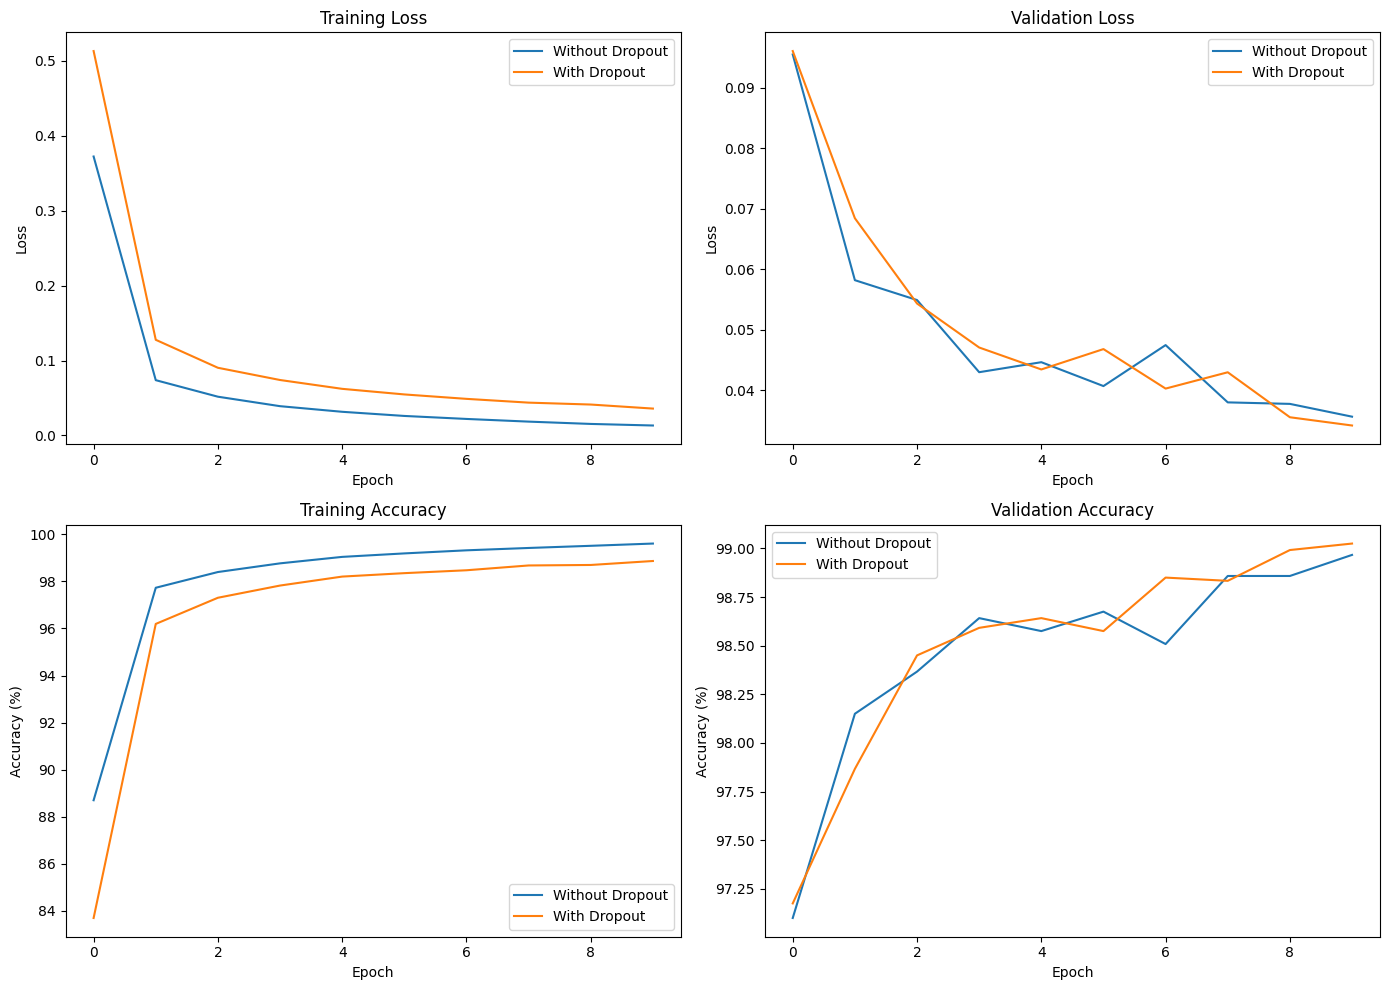

In [ ]:
# Plotting the Results
plt.figure(figsize=(14, 10))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(train_losses_without_dropout, label='Without Dropout')
plt.plot(train_losses_with_dropout, label='With Dropout')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(val_losses_without_dropout, label='Without Dropout')
plt.plot(val_losses_with_dropout, label='With Dropout')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(train_accuracies_without_dropout, label='Without Dropout')
plt.plot(train_accuracies_with_dropout, label='With Dropout')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 4)
plt.plot(val_accuracies_without_dropout, label='Without Dropout')
plt.plot(val_accuracies_with_dropout, label='With Dropout')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


*The initial training loss is lower for the model without dropout, indicating faster convergence. However, the model with dropout demonstrates more consistent validation loss and accuracy, indicating better generalization.*

*When analyzing these plots, the model with dropout achieves a slightly higher validation accuracy (and test accuracy) than the model without dropout, despite the model with dropout having a lower training accuracy compared to the model without dropout.*

*Dropout helps prevent overfitting, as seen from the smaller gap between training and validation performance. Though insignificant in our example, the difference becomes increasingly crucial when training more complex and larger models.*